# AHS Basic Usage <a class="anchor" id="TOC"></a>

2022-09-02

We demonstrate how to use the constructs of `braket.ahs` module to define valid Analog Hamiltonian Simulation (AHS) tasks, and run them on QuEra Aquila QPU via Amazon Braket. More specifically,

1. [Register](#register): we specify the register made of individually trapped neutral atoms in a 2-d `AtomArrangement`,
2. [Driving field](#driving-field): we specify the time-dependent `DrivingField` that coherently drives the transition between the ground and the Rydberg state,
3. [Shifting field](#shifting-field): we specify the time- and space-dependent `ShiftingField` that shifts the frequency of the Rydberg state,
4. [AHS](#ahs): we package these date together into a valid `AnalogHamiltonianSimulation` task object,
5. [Device](#device): we connect to the QPU (an `AwsDevice`), and investigate its capabilities,
6. [Task](#task): we submit the AHS task object to the QPU, and get a `QuantumTask` object, and
7. [Result](#result): we query the Braket service for results.

## Prerequisits

To use the Braket AHS module, we need to install the corresponding branches 

* `feature/ahs` branch of amazon-braket-sdk-python: https://github.com/aws/amazon-braket-sdk-python/tree/feature/ahs
* `quera` branch of amazon-braket-schemas-python: https://github.com/aws/amazon-braket-schemas-python/tree/quera

This can be done in the following way (recommended to be done in a virtual environment):

**Step 1**: Install the latest Braket package with the following command line
```bash
pip install amazon-braket-sdk --upgrade --upgrade-strategy eager
```
To confirm, run `pip freeze | grep braket`, which should return the following, or similar
```
amazon-braket-default-simulator==1.8.1
amazon-braket-schemas==1.10.2
amazon-braket-sdk==1.29.2
```

In [1]:
! pip freeze | grep braket

**Step 2**: Clone and install the `feature/ahs` branch of the SDK and the `quera` branch of the schemas repos
```bash
cd $YOUR_FAVORITE_DIRECTORY
git clone -b feature/ahs git@github.com:aws/amazon-braket-sdk-python.git
cd amazon-braket-sdk-python
pip install --no-dependencies --upgrade --force-reinstall -e .

cd $YOUR_FAVORITE_DIRECTORY
git clone -b quera git@github.com:aws/amazon-braket-schemas-python.git
cd amazon-braket-schemas-python
pip install --no-dependencies --upgrade --force-reinstall -e .
```

To confirm, run `pip freeze | grep braket` again, which should now return the following, or similar
```
amazon-braket-default-simulator==1.8.1
-e git+ssh://git@github.com/aws/amazon-braket-schemas-python.git@ba50127a19c095b969454a046e9d1ccf57ba5ad8#egg=amazon_braket_schemas
-e git+ssh://git@github.com/aws/amazon-braket-sdk-python.git@f5d6220497b6a491603abfc89a5a714dc1418906#egg=amazon_braket_sdk

```

In [2]:
! pip freeze | grep braket

Now, we are ready to use the Braket AHS module. 

We can check that indeed `braket.ahs` is imported from the desired location.

In [3]:
import braket.ahs
import braket.ir.ahs
print(braket.ahs.__file__)
print(braket.ir.ahs.__file__)

## 1. Register <a class="anchor" id="register"></a>
[back to top](#TOC)

We specify a 15x15 square lattice with some sites left empty

In [4]:
import numpy as np
from braket.ahs.atom_arrangement import AtomArrangement, SiteType

separation = 4e-6  # in meters 
k_max = 15
m_max = 15
vacancies = {
    (0, 1), (0, 8), (0, 11), (0, 12),
    (1, 8), (1, 9),
    (2, 10),
    (3, 12), (3, 13), (3, 14),
    (4, 3), (4, 4), (4, 7), (4, 13), (4, 14),
    (5, 7), (5, 13),
    (6, 6), (6, 8), (6, 11), (6, 14),
    (7, 0), (7, 4), (7, 5), (7, 8), (7, 11),
    (8, 1), (8, 6), (8, 13),
    (9, 6), (9, 9),
    (10, 1), (10, 2), (10, 5), (10, 6), (10, 7),
    (11, 4), (11, 10),
    (12, 8),
    (13, 5),
    (14, 2), (14, 4), (14, 8), (14, 9), (14, 11)
}
register = AtomArrangement()
for k in range(k_max):
    for m in range(m_max):
        if (k, m) not in vacancies:
            register.add((m * separation, (k_max-k-1) * separation))  # site_type is SiteType.FILLED by default
        else:
            register.add((m * separation, (k_max-k-1) * separation), site_type=SiteType.VACANT)

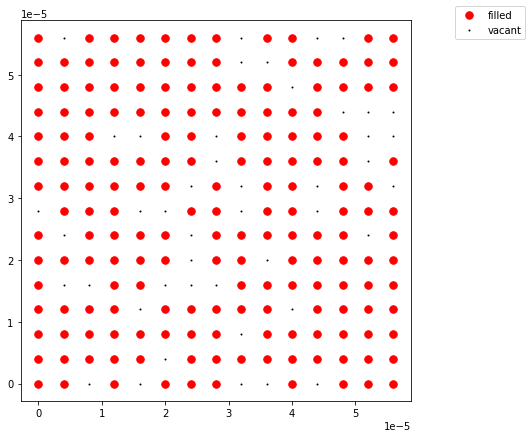

In [5]:
# [Optional] We visually inspect the register

import matplotlib.pyplot as plt

def show_register(register):
    filled_sites = [site.coordinate for site in register._sites if site.site_type == SiteType.FILLED]
    empty_sites = [site.coordinate for site in register._sites if site.site_type == SiteType.VACANT]
    fig = plt.figure(figsize=(7, 7))
    plt.plot(np.array(filled_sites)[:, 0], np.array(filled_sites)[:, 1], 'r.', ms=15, label='filled')
    plt.plot(np.array(empty_sites)[:, 0], np.array(empty_sites)[:, 1], '.', color='k', ms=2, label='vacant')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    
show_register(register)

## 2. Driving field <a class="anchor" id="driving-field"></a>
[back to top](#TOC)

We specify a uniform driving field that implements a simple adiabatic schedule, where
* the driving amplitude follows a trapezoid shape, and
* the detuning of the drive follows a constant ramp while the amplitude is constant, and
* the phase is kept constant zero.

In [6]:
from braket.ahs.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

amplitude_min = 0          # rad / s
amplitude_max = 25000000   # rad / s

detuning_min = -125000000  # rad / s
detuning_max = 125000000   # rad / s

time_max = 4e-6  # s
time_ramp = 1e-7  # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

amplitude = TimeSeries()
for t, v in zip(time_points, amplitude_values):
    amplitude.put(t, v)

detuning = TimeSeries()
for t, v in zip(time_points, detuning_values):
    detuning.put(t, v)

phase = TimeSeries()
for t, v in zip(time_points, phase_values):
    phase.put(t, v)

# Note: Since all attributes of QuEra Aquila's driving field are uniform,
#       we pass the TimeSeries objects directly to the constructor.
#       This will contruct braket.ahs.field.Field objects with uniform patterns for the attributes.
drive = DrivingField(
    amplitude=amplitude, 
    detuning=detuning, 
    phase=phase
)

In [7]:
drive?

Type:           DrivingField
String form:    <braket.ahs.driving_field.DrivingField object at 0x109b67a60>
File:           ~/Amazon/github/amazon-braket-sdk-python/src/braket/ahs/driving_field.py
Docstring:      <no docstring>
Init docstring:
Creates Hamiltonian Term for the Driving Field that coherently transfer atoms
from the ground state to the Rydberg state in an AnalogHamiltonianSimulation.

formula: ((Omega(t) / 2) * exp(1j * phi(t)) * Sum_k |g_k><r_k| + h.c.) - Delta(t) * Sum_k |r_k><r_k|  # noqa
states:
  |g_k> : ground state of atom k.
  |r_k> : Rydberg state of atom k.
other symbols:
  Sum_k : summation over all target atoms.
  h.c.  : Hermitian conjugate of the preceeding term.

Args:
    amplitude (Union[Field, TimeSeries]): global amplitude (Omega(t).
        Time is in s, and value is in rad/s.
    phase (Union[Field, TimeSeries]): global phase (phi(t)).
        Time is in s, and value is in rad/s.
    detuning (Union[Field, TimeSeries]): global detuning (Delta(t)).
     

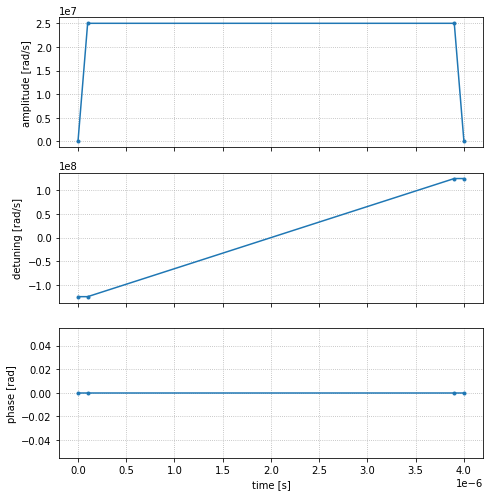

In [8]:
# [Optional] We visually inspect the attributes of the driving field

def show_global_drive(drive):
    data = {
        'amplitude [rad/s]': drive.amplitude.time_series,
        'detuning [rad/s]': drive.detuning.time_series,
        'phase [rad]': drive.phase.time_series,
    }
    
    fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)
    for ax, data_name in zip(axes, data.keys()):
        ax.plot(data[data_name].times(), data[data_name].values(), '.-')
        ax.set_ylabel(data_name)
        ax.grid(ls=':')
    axes[-1].set_xlabel('time [s]')
    plt.tight_layout()

show_global_drive(drive)

## 3. Shifting field <a class="anchor" id="shifting-field"></a>
[back to top](#TOC)

We specify the site-dependent shifting field, where
* the common shift magnitude follows a trapezoid pulse, and
* its site-dependent pattern is 100% for some sites and 50% for others

In [9]:
from braket.ahs.shifting_field import ShiftingField
from braket.ahs.field import Field
from braket.ahs.pattern import Pattern

local_detuning_min = 0          # rad/s
local_detuning_max = 125000000  # rad/s

local_detuning_magnitude_values = [local_detuning_min, local_detuning_max, local_detuning_max, local_detuning_min]
local_detuning_pattern = (
    [1.0] * 112     # first half of sites get full strength shift
    + [0.5] * 113   # second half of sites get half strength shift
)

magnitude_time_series = TimeSeries()
for t, v in zip(time_points, local_detuning_magnitude_values):
    magnitude_time_series.put(t, v)
magnitude_pattern = Pattern(local_detuning_pattern)

shift = ShiftingField(
    magnitude=Field(
        time_series=magnitude_time_series,
        pattern=magnitude_pattern,
    )
)

In [10]:
shift?

Type:           ShiftingField
String form:    <braket.ahs.shifting_field.ShiftingField object at 0x109cd5f60>
File:           ~/Amazon/github/amazon-braket-sdk-python/src/braket/ahs/shifting_field.py
Docstring:      <no docstring>
Init docstring:
Creates Hamiltonian Term for representing the Shifting Field that changes
the energy of the Rydberg level in an AnalogHamiltonianSimulation.

formula: - Delta(t) * Sum_k h_k |r_k><r_k|
states:
  |r_k> : Rydberg state of atom k.
other symbols:
  Sum_k : summation over all target atoms.

Args:
    magnitude (Field): containing the global magnitude time series (Delta(t)),
        where time measured in seconds (s) and values measured in rad/s) and the
        local pattern of unitless real numbers between 0 and 1 (h_k).


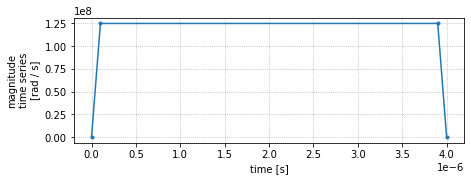

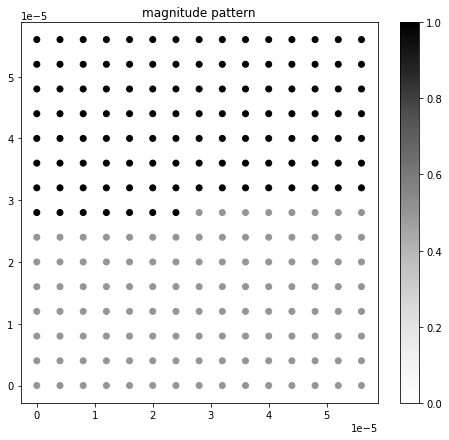

In [11]:
# [Optional] We visually inspect the site-depedent shifting field

def show_local_shift(shift, register):
    common_detuning = shift.magnitude.time_series
    site_coefficients = shift.magnitude.pattern
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 2.3))
    ax.plot(common_detuning.times(), common_detuning.values(), '.-')
    ax.grid(ls=':')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('magnitude\ntime series\n[rad / s]')
    
    fig = plt.figure(figsize=(8, 7))
    sites_x = register.coordinate_list(0)
    sites_y = register.coordinate_list(1)
    plt.scatter(sites_x, sites_y, c=site_coefficients.series, cmap='Greys', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('magnitude pattern')
    
show_local_shift(shift, register)

## 4. AHS <a class="anchor" id="ahs"></a>
[back to top](#TOC)

We specify the Hamiltonian as the sum of driving and shifting fields (we implicitly assume the Rydberg-Rydberg interaction between pairs of atoms).

The AHS program is then created from the register and the Hamiltonian.

In [12]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

hamiltonian = Hamiltonian()
hamiltonian += drive + shift

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=hamiltonian
)

## 5. Device <a class="anchor" id="device"></a>
[back to top](#TOC)

We query the Aquila QPU on the Braket service using its unique Amazon Resource Number (ARN).

In [10]:
from braket.aws import AwsDevice

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
print(qpu)

Device('name': Aquila, 'arn': arn:aws:braket:us-east-1::device/qpu/quera/Aquila)


In [21]:
# [Optional] We print values to the screen for inspection by a human

import json
json.loads(qpu.properties.paradigm.json())

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
  'version': '1'},
 'qubitCount': 256,
 'lattice': {'area': {'width': 0.0001, 'height': 0.0001},
  'geometry': {'spacingRadialMin': 4e-06,
   'spacingVerticalMin': 2.5e-06,
   'positionResolution': 1e-07,
   'numberSitesMax': 256}},
 'rydberg': {'c6Coefficient': 5.42e-24,
  'rydbergGlobal': {'rabiFrequencyRange': [0, 25000000.0],
   'rabiFrequencyResolution': 400,
   'rabiFrequencySlewRateMax': 250000000000000.0,
   'detuningRange': [-125000000.0, 125000000.0],
   'detuningResolution': 0.2,
   'detuningSlewRateMax': 2500000000000000.0,
   'phaseRange': [-99.0, 99.0],
   'phaseResolution': 5e-07,
   'phaseSlewRateMax': 62000000.0,
   'timeResolution': 1e-09,
   'timeDeltaMin': 1e-08,
   'timeMin': 0,
   'timeMax': 4e-06},
  'rydbergLocal': {'detuningRange': [0, 125000000.0],
   'commonDetuningResolution': 2000.0,
   'localDetuningResolution': 0.01,
   'detuningSlewRateMax': 1250000000000000.0,
  

In [36]:
# [Optional] We print values and detailed description of one particular section

section = qpu.properties.paradigm.lattice.geometry
print(type(section))
print(section)
print(section.__doc__)

<class 'braket.device_schema.quera.quera_ahs_paradigm_properties_v1.Geometry'>
spacingRadialMin=Decimal('0.000004') spacingVerticalMin=Decimal('0.0000025') positionResolution=Decimal('1E-7') numberSitesMax=256

    Spacing or number of sites or rows
    Attributes:
        spacingRadialMin (Decimal): Minimum radial spacing between any
            two sites in the lattice (measured in meters)
        spacingVerticalMin (Decimal): Minimum spacing between any two
            rows in the lattice (measured in meters)
        positionResolution (Decimal): Resolution with which site positions
            can be specified (measured in meters)
        numberSitesMax (int): Maximum number of sites that can be placed
            in the lattice
    


## 6. Task <a class="anchor" id="task"></a>
[back to top](#TOC)

The AHS program can be submitted to the device to create a quantum task on the Braket service.

In [72]:
# To ensure that the program complies with resolution-specific validation rules

discretized_ahs_program = ahs_program.discretize(qpu)

In [73]:
# [Optional] Compare original and discretized AHS programs

for original, discretized in zip (
    ahs_program.hamiltonian.terms[0].amplitude.time_series.times(),
    discretized_ahs_program.hamiltonian.terms[0].amplitude.time_series.times(),
):
    print(original.__repr__(), discretized.__repr__())

0 Decimal('0E-9')
1e-07 Decimal('1.00E-7')
3.9e-06 Decimal('0.000003900')
4e-06 Decimal('0.000004000')


In [74]:
task = qpu.run(discretized_ahs_program, shots=100)
print(task)

AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:606892779558:quantum-task/8ea634c1-366e-4d76-8831-9a133c9274d3')


In [76]:
# [Optional] We can investigate task metadata

task.metadata()

{'ResponseMetadata': {'RequestId': 'c7dfb2f5-b63b-4da7-b1e1-16d5af607683',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 02 Sep 2022 19:54:01 GMT',
   'content-type': 'application/json',
   'content-length': '564',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c7dfb2f5-b63b-4da7-b1e1-16d5af607683',
   'access-control-allow-origin': '*',
   'strict-transport-security': 'max-age=63072000; includeSubDomains; preload',
   'access-control-allow-headers': '*,authorization,date,x-amz-date,x-amz-security-token,x-amz-target,content-type,x-amz-content-sha256,x-amz-user-agent,x-amzn-platform-id,x-amzn-trace-id',
   'x-amz-apigw-id': 'X2PWDHRhoAMFUWQ=',
   'access-control-allow-methods': 'OPTIONS,GET,PUT,POST,DELETE',
   'access-control-expose-headers': 'x-amzn-errortype,x-amzn-requestid,x-amzn-errormessage,x-amzn-trace-id,x-amz-apigw-id,date',
   'x-amzn-trace-id': 'Root=1-63125f59-295d2f3b6d6730225dd47a39'},
  'RetryAttempts': 0},
 'createdAt': datetime.datetime(2022, 9, 2, 1

## 7. Result <a class="anchor" id="result"></a>
[back to top](#TOC)

The results (once the task is completed) can be downloaded directly into an object in the python session.

In [ ]:
result = task.result()

result_dict = dict(braket_results.json())

The call `task.result()` is blocking execution until the task is completed and results are loaded from Amazon Braket. The `result_dict` dictionary has the following structure (Disclaimer: sizes and values are not representative of the particular `task` object at hand in the example).
```python
{"braketSchemaHeader": {"name": "braket.task_result.analog_hamiltonian_simulation_task_result", "version": "1"}, "taskMetadata": {"braketSchemaHeader": {"name": "braket.task_result.task_metadata", "version": "1"}, "id": "QuEra-SPAM-simulation-task-bdee72e4-2afb-11ed-8f32-acde48001122", "shots": 2, "deviceId": "QuEra-SPAM-simulator-1", "deviceParameters": null, "createdAt": "2022-09-02T20:13:42.893Z", "endedAt": "2022-09-02T20:13:43.003Z", "status": "Completed", "failureReason": null}, "measurements": [{"shotMetadata": {"shotStatus": "Success"}, "shotResult": {"preSequence": [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "postSequence": [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, {"shotMetadata": {"shotStatus": "Success"}, "shotResult": {"preSequence": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "postSequence": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}]}
```